In [1]:
import numpy as np
import pandas as pd 
import astropy.io.ascii as ascii
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import PIL
from PIL import Image
import sys
import os
import matplotlib.image as mp
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.image as mp
from astropy.visualization import LinearStretch
from astropy.visualization import ZScaleInterval
from astropy.visualization import ImageNormalize
import corner
import math

# Defining functions

In [2]:
def match2(catalogue1, catalogue2, ra1 = 'X_WORLD', dec1 = 'Y_WORLD', ra2 = 'X_WORLD', dec2 = 'Y_WORLD'):

    threshold = 1.0
    
    coord1 = SkyCoord(ra=catalogue1[ra1], dec=catalogue1[dec1],unit='deg')
    coord2 = SkyCoord(ra=catalogue2[ra2], dec=catalogue2[dec2],unit='deg')

    idx, d2d, d3d = coord1.match_to_catalog_sky(coord2)

    max_sep = threshold * u.arcsec

    sep_constraint = d2d < max_sep

    global data1_12_matches
    try: data1_12_matches = catalogue1[sep_constraint]
    except IndexError: 
        pass 
    
    global data2_12_matches
    data2_12_matches = catalogue2.iloc[idx[sep_constraint]]

def match3(catalogue1, catalogue2, catalogue3):
    xworld1 = catalogue1['X_WORLD']
    yworld1 = catalogue1['Y_WORLD']

    xworld2 = catalogue2['X_WORLD']
    yworld2 = catalogue2['Y_WORLD']
    
    xworld3 = catalogue3['X_WORLD']
    yworld3 = catalogue3['Y_WORLD']
    
    coord1 = SkyCoord(ra=xworld1*u.degree, dec=yworld1*u.degree)
    coord2 = SkyCoord(ra=xworld2*u.degree, dec=yworld2*u.degree)

    
    idx, d2d, d3d = coord1.match_to_catalog_sky(coord2)
    
    max_sep = 1.0 * u.arcsec

    sep_constraint = d2d < max_sep
    
    data1_12_matches = catalogue1[sep_constraint]
    data2_12_matches = catalogue2.iloc[idx[sep_constraint]]
    
    xworld1_12 = data1_12_matches['X_WORLD']
    yworld1_12 = data1_12_matches['Y_WORLD']
    
    coord1_12 = SkyCoord(ra=xworld1_12*u.degree, dec=yworld1_12*u.degree)
    coord3 = SkyCoord(ra=xworld3*u.degree, dec=yworld3*u.degree)
    
    idx, d2d, d3d = coord1_12.match_to_catalog_sky(coord3)
    
    max_sep = 1.0 * u.arcsec

    sep_constraint = d2d < max_sep
    
    global data1_123_matches
    data1_123_matches = data1_12_matches[sep_constraint]
    global data2_123_matches
    data2_123_matches = data2_12_matches[sep_constraint]
    global data3_123_matches
    data3_123_matches = catalogue3.iloc[idx[sep_constraint]]

# The Photometry Part

Reading in the files: 

In [3]:
#reading in files 
ref = pd.read_csv('GRB210605A5_APASS.csv') #reference  
temp_g = ascii.read('GRB210605A5_g_stacked_temp.resamp_TEMP.cat') #temp
temp_g = pd.DataFrame(temp_g.as_array())

temp_i = ascii.read('GRB210605A5_i_stacked_temp.resamp_TEMP.cat') #temp
temp_i = pd.DataFrame(temp_i.as_array())

#getting only the ra and dec of each catalogue 
ref_ra = ref['radeg']
ref_dec = ref['decdeg']

temp_g_ra = temp_g['X_WORLD']
temp_g_dec = temp_g['Y_WORLD']

temp_i_ra = temp_i['X_WORLD']
temp_i_dec = temp_i['Y_WORLD']

In [4]:
print(len(ref))
print(len(temp_g))
print(len(temp_i))

2865
61586
53678


# Plotting down the sources in both the reference and template

In [5]:
#finding the max and min values of the ra and dec in the corrected template image
min_g_ra = temp_g_ra.min()
max_g_ra = temp_g_ra.max()

min_i_ra = temp_i_ra.min()
max_i_ra = temp_i_ra.max()

min_g_dec = temp_g_dec.min()
max_g_dec = temp_g_dec.max()

min_i_dec = temp_i_dec.min()
max_i_dec = temp_i_dec.max()

#choosing the points in the template image based on the template image values
ref_g_select = ref[(ref['radeg']<max_g_ra) & (ref['radeg']>min_g_ra) & (ref['decdeg']<max_g_dec) & (ref['decdeg']>min_g_dec)]
ref_g_raf = ref_g_select['radeg']
ref_g_decf = ref_g_select['decdeg']

ref_i_select = ref[(ref['radeg']<max_i_ra) & (ref['radeg']>min_i_ra) & (ref['decdeg']<max_i_dec) & (ref['decdeg']>min_i_dec)]
ref_i_raf = ref_i_select['radeg']
ref_i_decf = ref_i_select['decdeg']

In [6]:
#FWHM of the template data
print(np.average(temp_g['FWHM_IMAGE']))
print(np.average(temp_i['FWHM_IMAGE']))

8.152377326015653
7.406603822795186


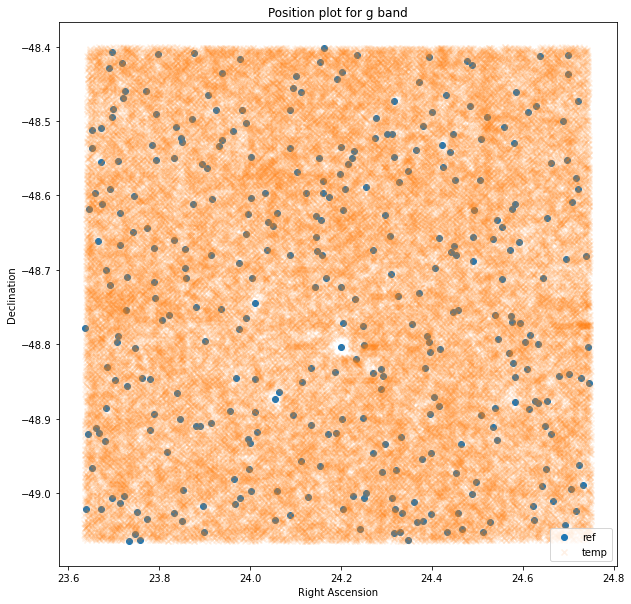

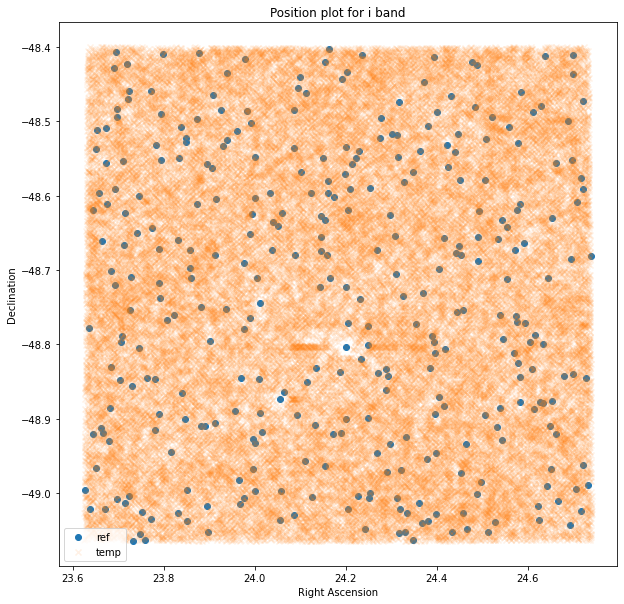

In [7]:
#plotting down all points within the chosen range
plt.figure(figsize=(10,10))
plt.title('Position plot for g band')
plt.scatter(ref_g_raf, ref_g_decf, marker = 'o', label = 'ref')
plt.scatter(temp_g_ra, temp_g_dec, marker = 'x', label = 'temp', alpha=0.1 ) 
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.legend()

plt.figure(figsize=(10,10))
plt.title('Position plot for i band')
plt.scatter(ref_i_raf, ref_i_decf, marker = 'o', label = 'ref')
plt.scatter(temp_i_ra, temp_i_dec, marker = 'x', label = 'temp', alpha=0.1 ) 
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.legend()

# Finding out why there are 2 linear curves...

In [8]:
#finding the matches between the 2 catalogues
match2(ref, temp_g, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
ref_temp_g = data1_12_matches
temp_g_ref = data2_12_matches

match2(ref, temp_i, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
ref_temp_i = data1_12_matches
temp_i_ref = data2_12_matches

Plotting 5 parameters for 323 data points (exposures).


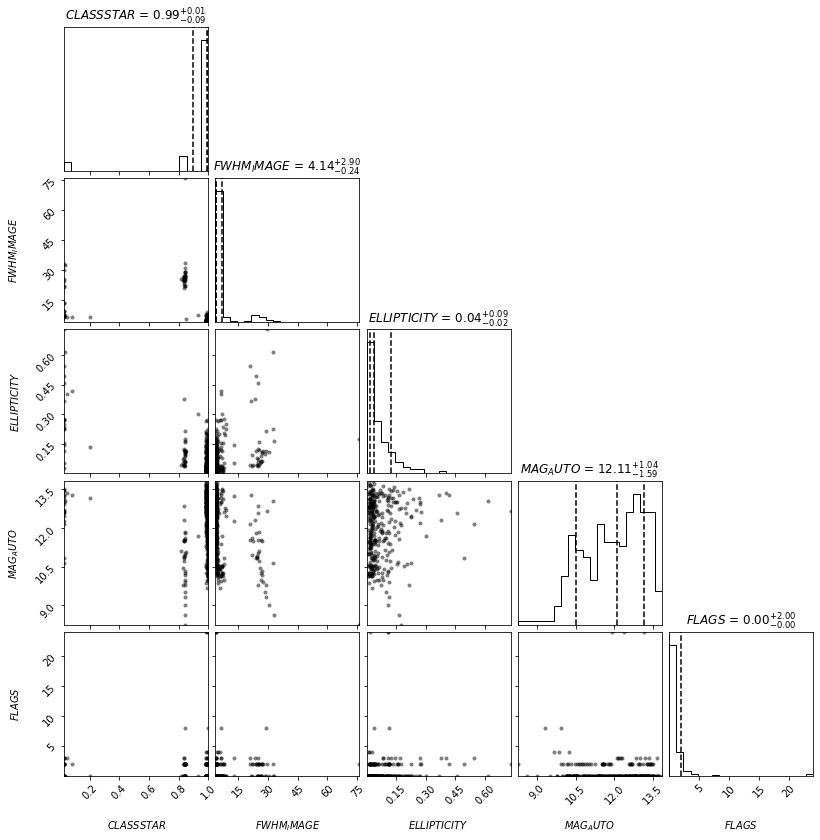

In [9]:
data = np.transpose([temp_g_ref['CLASS_STAR'], 
                     temp_g_ref['FWHM_IMAGE'], 
                     temp_g_ref['ELLIPTICITY'],
                     temp_g_ref['MAG_AUTO'],
                     temp_g_ref['FLAGS']
                    ])
print(f'Plotting {np.shape(data)[1]} parameters for {np.shape(data)[0]} data points (exposures).')

figure = corner.corner(data, labels=[r"$CLASS STAR$", r"$FWHM_IMAGE$", r"$ELLIPTICITY$", r"$MAG_AUTO$", r"$FLAGS$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},
                       plot_contours=False,plot_datapoints=True,plot_density=False,
                       data_kwargs={'alpha':0.5,'ms':4.0})

Plotting 5 parameters for 320 data points (exposures).


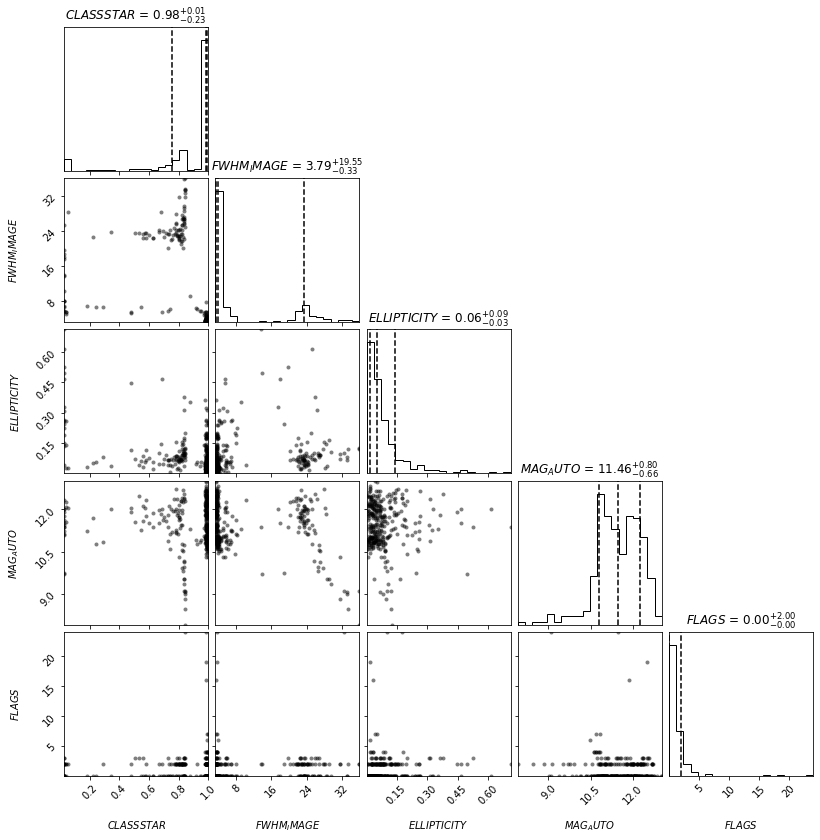

In [10]:
data = np.transpose([temp_i_ref['CLASS_STAR'], 
                     temp_i_ref['FWHM_IMAGE'], 
                     temp_i_ref['ELLIPTICITY'],
                     temp_i_ref['MAG_AUTO'],
                     temp_i_ref['FLAGS']
                    ])
print(f'Plotting {np.shape(data)[1]} parameters for {np.shape(data)[0]} data points (exposures).')

figure = corner.corner(data, labels=[r"$CLASS STAR$", r"$FWHM_IMAGE$", r"$ELLIPTICITY$", r"$MAG_AUTO$", r"$FLAGS$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},
                       plot_contours=False,plot_datapoints=True,plot_density=False,
                       data_kwargs={'alpha':0.5,'ms':4.0})

# There are 2 groups in the data; 1 that seems about right (group A) and the other that seems to misrepresent the data (group B)

# Here, we are filtering the data for group B to see them more clearly:

37
53
37
323
323


7.311505232432431

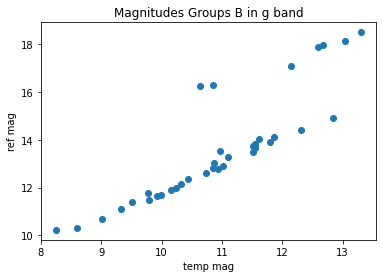

In [11]:
test_comb = temp_g_ref[((temp_g_ref['CLASS_STAR'] < 0.95) & (temp_g_ref['FWHM_IMAGE'] > 15))]
test_class_star = temp_g_ref[temp_g_ref['CLASS_STAR'] < 0.95]
test_fwhm = temp_g_ref[temp_g_ref['FWHM_IMAGE'] > 15]

print(len(test_comb))
print(len(test_class_star))
print(len(test_fwhm))

match2(ref, test_comb, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
print(len(ref_temp_g))
print(len(temp_g_ref))

plt.title('Magnitudes Groups B in g band')
plt.scatter(data2_12_matches['MAG_AUTO'], data1_12_matches['Sloan_g (SG)'])
plt.xlabel('temp mag')
plt.ylabel('ref mag')

data2_12_matches.sort_values('FWHM_IMAGE', ascending = True) #these are the sources that are making the linear graph weird
np.average(data2_12_matches['FWHM_WORLD']) * 3600

82
108
82
320
320


6.613873331707318

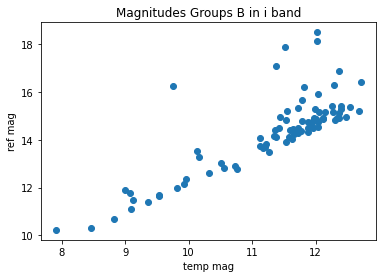

In [12]:
test_comb = temp_i_ref[((temp_i_ref['CLASS_STAR'] < 0.95) & (temp_i_ref['FWHM_IMAGE'] > 15))]
test_class_star = temp_i_ref[temp_i_ref['CLASS_STAR'] < 0.95]
test_fwhm = temp_i_ref[temp_i_ref['FWHM_IMAGE'] > 15]

print(len(test_comb))
print(len(test_class_star))
print(len(test_fwhm))

match2(ref, test_comb, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
print(len(ref_temp_i))
print(len(temp_i_ref))

plt.title('Magnitudes Groups B in i band')
plt.scatter(data2_12_matches['MAG_AUTO'], data1_12_matches['Sloan_g (SG)'])
plt.xlabel('temp mag')
plt.ylabel('ref mag')

data2_12_matches.sort_values('FWHM_IMAGE', ascending = True) #these are the sources that are making the linear graph weird
np.average(data2_12_matches['FWHM_WORLD']) * 3600

# Now we are filtering the data just for group A, which is the data that we want to use

In [13]:
#finding the matches between the 2 catalogues
match2(ref, temp_g, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
data2_12_matches.keys()

Index(['NUMBER', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_RADIUS', 'FLUX_APER',
       'FLUXERR_APER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'FLAGS',
       'CLASS_STAR', 'MAG_AUTO', 'MAGERR_AUTO', 'MAG_ISO', 'MAGERR_ISO',
       'BACKGROUND', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'THETA_SKY',
       'ISOAREA_IMAGE', 'FWHM_IMAGE', 'FWHM_WORLD', 'ISOAREAF_IMAGE',
       'ELLIPTICITY'],
      dtype='object')

270
53
37
270
270


1.15721184

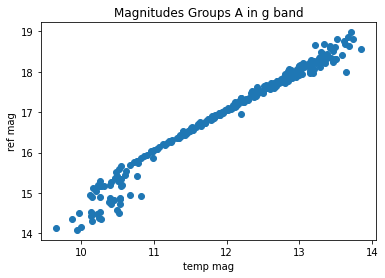

In [14]:
test_comb = data2_12_matches[((data2_12_matches['CLASS_STAR'] > 0.95) & (data2_12_matches['FWHM_IMAGE'] < 15))]
test_class_star = data2_12_matches[data2_12_matches['CLASS_STAR'] < 0.95]
test_fwhm = data2_12_matches[data2_12_matches['FWHM_IMAGE'] > 15]

print(len(test_comb))
print(len(test_class_star))
print(len(test_fwhm))

match2(ref, test_comb, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
print(len(data1_12_matches))
print(len(data2_12_matches))

plt.title('Magnitudes Groups A in g band')
plt.scatter(data2_12_matches['MAG_AUTO'], data1_12_matches['Sloan_g (SG)'])
plt.xlabel('temp mag')
plt.ylabel('ref mag')

data2_12_matches.sort_values('FWHM_WORLD', ascending = True) #these are the majority of sources
np.average(data2_12_matches['FWHM_WORLD']) * 3600 

212
108
82
212
212


0.9959525422641508

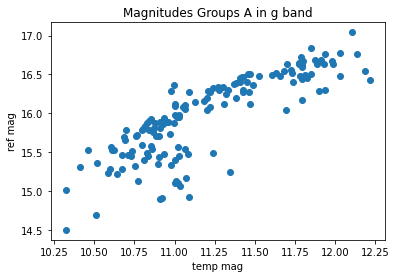

In [15]:
#finding the matches between the 2 catalogues
match2(ref, temp_i, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')

test_comb = data2_12_matches[((data2_12_matches['CLASS_STAR'] > 0.95) & (data2_12_matches['FWHM_IMAGE'] < 15))]
test_class_star = data2_12_matches[data2_12_matches['CLASS_STAR'] < 0.95]
test_fwhm = data2_12_matches[data2_12_matches['FWHM_IMAGE'] > 15]

print(len(test_comb))
print(len(test_class_star))
print(len(test_fwhm))

match2(ref, test_comb, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
print(len(data1_12_matches))
print(len(data2_12_matches))

plt.title('Magnitudes Groups A in g band')
plt.scatter(data2_12_matches['MAG_AUTO'], data1_12_matches['Sloan_i (SI)'])
plt.xlabel('temp mag')
plt.ylabel('ref mag')

data2_12_matches.sort_values('FWHM_WORLD', ascending = True) #these are the majority of sources
np.average(data2_12_matches['FWHM_WORLD']) * 3600 

# These are the sources that we're interested in (Group A) for the g band and (Group B) in the i band

In [16]:
match2(ref, temp_g, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
data2_12_matches = data2_12_matches[((data2_12_matches['CLASS_STAR'] > 0.95) & (data2_12_matches['FWHM_IMAGE'] < 15))]
data1_12_matches.keys()

Index(['radeg', 'raerr(")', 'decdeg', 'decerr(")', 'Johnson_V (V)', 'Verr',
       'Vnobs', 'Johnson_B (B)', 'Berr', 'Bnobs', 'Sloan_u (SU)', 'SUerr',
       'SUnobs', 'Sloan_g (SG)', 'SGerr', 'SGnobs', 'Sloan_r (SR)', 'SRerr',
       'SRnobs', 'Sloan_i (SI)', 'SIerr', 'SInobs', 'Sloan_z (SZ)', 'SZerr',
       'SZnobs', 'PanSTARRS_Y (Y)', 'Yerr', 'Ynobs'],
      dtype='object')

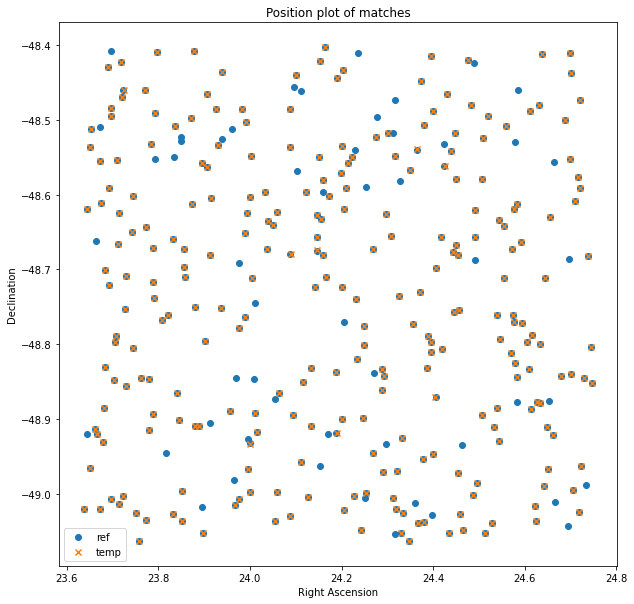

In [17]:
#plotting down the matches between the catalogues
plt.figure(figsize=(10,10))
plt.title('Position plot of matches')
plt.scatter(data1_12_matches['radeg'], data1_12_matches['decdeg'], marker = 'o', label = 'ref')
plt.scatter(data2_12_matches['X_WORLD'], data2_12_matches['Y_WORLD'], marker = 'x', label = 'temp') 
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.legend()

In [18]:
#reseting index 
data1 = data1_12_matches.reset_index()
data2 = data2_12_matches.reset_index()

In [19]:
#finding the difference in magnitudes for the zero point
zero_pts = data2['MAG_AUTO'] - data1['Sloan_g (SG)']
zero_pt = np.nanmean(zero_pts)
zero_pt_err = np.nanstd(zero_pts)
print(zero_pt, zero_pt_err)


-4.609791044776119 1.9660611817457678


In [20]:
zero_pts
print(len(zero_pts))

323


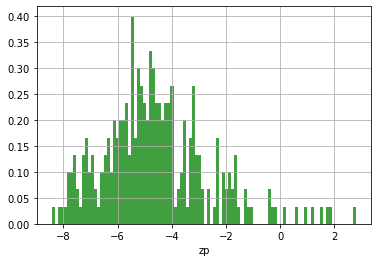

In [21]:
#plotting down the distribution of different zero points
n, bins, patches = plt.hist(zero_pts, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()


In [22]:
# looking at the corrected values vs the uncorrected values 
temp_g['MAG_AUTO']

0        20.7326
1        20.8888
2        20.9426
3        20.1886
4        20.6170
          ...   
61581    20.1838
61582    20.7829
61583    20.4065
61584    18.6691
61585    20.2946
Name: MAG_AUTO, Length: 61586, dtype: float64

In [23]:
#writing in the corrected csv file
temp_g['MAG_AUTO'] =  temp_g['MAG_AUTO'] + zero_pt #the values in the temp - zero point 
temp_g

,NUMBER,FLUX_AUTO,FLUXERR_AUTO,FLUX_RADIUS,FLUX_APER,FLUXERR_APER,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,...,BACKGROUND,A_IMAGE,B_IMAGE,THETA_IMAGE,THETA_SKY,ISOAREA_IMAGE,FWHM_IMAGE,FWHM_WORLD,ISOAREAF_IMAGE,ELLIPTICITY
0,1,50.93025,8.629296,1.632,35.37298,5.948482,3179.6162,1.9090,24.392911,-49.064668,...,-0.114101,1.011,0.646,-28.42,61.48,6,4.80,0.000355,10,0.361
1,2,44.10587,12.907190,1.709,30.99164,6.148931,5870.5215,2.2225,24.088888,-49.064770,...,0.000301,0.957,0.707,-2.30,87.78,6,4.89,0.000362,10,0.262
2,3,41.97048,10.384190,1.636,34.27871,5.911186,978.6272,1.8740,24.641574,-49.063975,...,0.031156,1.386,0.617,-30.41,59.38,10,5.51,0.000408,11,0.555
3,4,84.05503,13.494850,2.205,47.72965,6.150115,5593.8569,2.1626,24.120146,-49.064798,...,0.055573,1.414,0.808,24.88,-65.08,14,6.38,0.000472,16,0.429
4,5,56.65252,12.078360,2.212,31.05913,5.776231,3424.4631,1.7172,24.365248,-49.064727,...,-0.009765,1.512,0.713,24.34,-65.76,8,5.28,0.000391,17,0.529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61581,61582,84.42363,11.839610,1.915,62.22750,6.524804,8845.4248,8699.8721,23.758393,-48.420140,...,-0.009154,1.428,1.142,34.69,-55.13,20,6.15,0.000455,24,0.200
61582,61583,48.62162,15.562350,2.142,29.49115,6.465636,8080.1299,8817.5918,23.843813,-48.411716,...,0.004924,1.602,0.629,21.53,-68.27,8,5.98,0.000443,12,0.607
61583,61584,68.77173,11.281230,1.896,49.24508,6.478115,3775.7102,8705.7598,24.323879,-48.420449,...,-0.029203,1.456,1.045,39.85,-50.20,13,7.37,0.000546,21,0.282
61584,61585,340.68100,18.903600,2.625,160.77940,6.662041,1921.4008,8620.2051,24.530753,-48.426363,...,-0.025245,2.359,1.853,-30.50,59.35,59,7.54,0.000558,76,0.215


In [24]:
temp_g['MAG_AUTO']

0        16.122809
1        16.279009
2        16.332809
3        15.578809
4        16.007209
           ...    
61581    15.574009
61582    16.173109
61583    15.796709
61584    14.059309
61585    15.684809
Name: MAG_AUTO, Length: 61586, dtype: float64

In [25]:
temp_g.to_csv('GRB210605A5_g_stacked_temp.resamp_TEMP_CORRECTED.csv') #writing the corrected csv file

-5.795690243902439 1.786135593657214


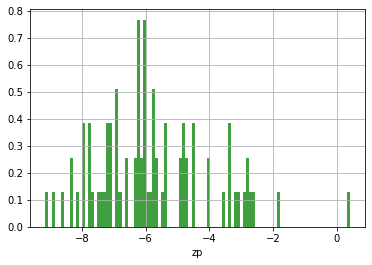

In [26]:
# for the i band
match2(ref, temp_i, ra1 = 'radeg', dec1 = 'decdeg', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
data2_12_matches = data2_12_matches[((data2_12_matches['CLASS_STAR'] < 0.95) & (data2_12_matches['FWHM_IMAGE'] > 15))]
data1_12_matches.keys()

data1 = data1_12_matches.reset_index()
data2 = data2_12_matches.reset_index()

#finding the difference in magnitudes for the zero point
zero_pts = data2['MAG_AUTO'] - data1['Sloan_g (SG)']
zero_pt = np.nanmean(zero_pts)
zero_pt_err = np.nanstd(zero_pts)
print(zero_pt, zero_pt_err)

#plotting down the distribution of different zero points
n, bins, patches = plt.hist(zero_pts, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()

In [27]:
# looking at the corrected values vs the uncorrected values 
temp_i['MAG_AUTO']

0        19.9865
1        19.1296
2        19.9410
3        19.5952
4        19.2949
          ...   
53673    17.0943
53674    18.8372
53675    18.0192
53676    15.4014
53677    15.7661
Name: MAG_AUTO, Length: 53678, dtype: float64

In [28]:
#writing in the corrected csv file
temp_i['MAG_AUTO'] =  temp_i['MAG_AUTO'] + zero_pt #the values in the temp - zero point 
temp_i

,NUMBER,FLUX_AUTO,FLUXERR_AUTO,FLUX_RADIUS,FLUX_APER,FLUXERR_APER,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,...,BACKGROUND,A_IMAGE,B_IMAGE,THETA_IMAGE,THETA_SKY,ISOAREA_IMAGE,FWHM_IMAGE,FWHM_WORLD,ISOAREAF_IMAGE,ELLIPTICITY
0,1,101.2522,18.86585,1.238,100.6512,15.07855,2862.9827,1.7352,24.418045,-49.064565,...,-0.126038,1.089,0.725,5.29,-84.88,10,4.62,0.000342,11,0.334
1,2,222.9332,36.34550,2.014,145.7025,15.29422,5486.9731,1.8765,24.121584,-49.064777,...,-0.125033,2.043,0.762,0.25,-89.70,20,7.46,0.000552,23,0.627
2,3,105.5861,24.71502,1.466,86.0891,15.08782,6530.4067,1.7462,24.003695,-49.064664,...,0.019821,0.979,0.706,-1.26,88.88,8,4.94,0.000366,10,0.279
3,4,145.1832,24.15157,2.237,81.1174,14.66581,7582.3154,1.5910,23.884851,-49.064430,...,0.338733,2.131,0.670,-3.56,86.66,10,7.14,0.000529,17,0.686
4,5,191.4434,23.27528,1.854,137.8856,15.17766,8160.7549,1.7885,23.819500,-49.064228,...,-0.321755,1.669,0.719,5.28,-84.45,14,6.54,0.000484,18,0.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53673,53674,1453.0210,63.18697,3.260,514.1783,16.97567,5687.2012,8947.3232,24.100062,-48.402562,...,-0.034806,3.132,2.327,-14.70,75.36,85,10.69,0.000792,116,0.257
53674,53675,291.8226,62.78060,3.734,80.6055,16.73912,8720.2227,8880.1191,23.761836,-48.406798,...,0.008131,1.695,1.123,-81.97,8.34,11,8.25,0.000611,17,0.337
53675,53676,619.9109,43.36981,2.408,325.0039,16.83194,8783.4941,8517.7773,23.754554,-48.433593,...,-0.016746,2.085,1.622,-72.34,17.93,40,9.11,0.000674,53,0.222
53676,53677,6909.5090,54.34487,2.080,4152.7060,18.95482,7684.4902,8693.4326,23.877247,-48.420981,...,0.089308,2.507,2.110,77.33,-12.46,147,3.42,0.000253,189,0.158


In [29]:
temp_i['MAG_AUTO']

0        14.19081
1        13.33391
2        14.14531
3        13.79951
4        13.49921
           ...   
53673    11.29861
53674    13.04151
53675    12.22351
53676     9.60571
53677     9.97041
Name: MAG_AUTO, Length: 53678, dtype: float64

In [30]:
temp_i.to_csv('GRB210605A5_i_stacked_temp.resamp_TEMP_CORRECTED.csv') #writing the corrected csv file

# Now we will do the photometry for the subtraction image: 

## First, we will start with finding the matches between the template and science images

In [31]:
#for the sci_CORRECTED: it should be science - temp 
temp_g = pd.read_csv('GRB210605A5_g_stacked_temp.resamp_TEMP_CORRECTED.csv')
temp_i = pd.read_csv('GRB210605A5_i_stacked_temp.resamp_TEMP_CORRECTED.csv')

sci08g = ascii.read('GRB210605A5_20210608_g_stack_ext5.resamp_withnans_SCI_CORRECTED.cat')
sci09g = ascii.read('GRB210605A5_20210609_g_stack_ext5.resamp_withnans_SCI_CORRECTED.cat')
sci10g = ascii.read('GRB210605A5_20210610_g_stack_ext5.resamp_withnans_SCI_CORRECTED.cat')

sci08i = ascii.read('GRB210605A5_20210608_i_stack_ext5.resamp_withnans_SCI_CORRECTED.cat')
sci09i = ascii.read('GRB210605A5_20210609_i_stack_ext5.resamp_withnans_SCI_CORRECTED.cat')
sci10i = ascii.read('GRB210605A5_20210610_i_stack_ext5.resamp_withnans_SCI_CORRECTED.cat')

# temp = pd.DataFrame(temp)
sci08g = pd.DataFrame(sci08g.as_array())
sci09g = pd.DataFrame(sci09g.as_array())
sci10g = pd.DataFrame(sci10g.as_array())

sci08i = pd.DataFrame(sci08i.as_array())
sci09i = pd.DataFrame(sci09i.as_array())
sci10i = pd.DataFrame(sci10i.as_array())

temp_g = temp_g[((temp_g['MAG_AUTO'] < 30) & (temp_g['MAG_AUTO'] > 0))]
sci08g = sci08g[((sci08g['MAG_AUTO'] < 30) & (sci08g['MAG_AUTO'] > 0))]
sci09g = sci09g[((sci09g['MAG_AUTO'] < 30) & (sci09g['MAG_AUTO'] > 0))]
sci10g = sci10g[((sci10g['MAG_AUTO'] < 30) & (sci10g['MAG_AUTO'] > 0))]

temp_i = temp_i[((temp_i['MAG_AUTO'] < 30) & (temp_i['MAG_AUTO'] > 0))]
sci08i = sci08i[((sci08i['MAG_AUTO'] < 30) & (sci08i['MAG_AUTO'] > 0))]
sci09i = sci09i[((sci09i['MAG_AUTO'] < 30) & (sci09i['MAG_AUTO'] > 0))]
sci10i = sci10i[((sci10i['MAG_AUTO'] < 30) & (sci10i['MAG_AUTO'] > 0))]

# Now to match the subtraction to the science-template images

In [32]:
sub08g = ascii.read('GRB210605A5_20210608_g_stack_ext5.resamp_sub_withnans_SUB.cat')
sub09g = ascii.read('GRB210605A5_20210609_g_stack_ext5.resamp_sub_withnans_SUB.cat')
sub10g = ascii.read('GRB210605A5_20210610_g_stack_ext5.resamp_sub_withnans_SUB.cat')

sub08i = ascii.read('GRB210605A5_20210608_i_stack_ext5.resamp_sub_withnans_SUB.cat')
sub09i = ascii.read('GRB210605A5_20210609_i_stack_ext5.resamp_sub_withnans_SUB.cat')
sub10i = ascii.read('GRB210605A5_20210610_i_stack_ext5.resamp_sub_withnans_SUB.cat')

sub08g = pd.DataFrame(sub08g.as_array())
sub09g = pd.DataFrame(sub09g.as_array())
sub10g = pd.DataFrame(sub10g.as_array())

sub08i = pd.DataFrame(sub08i.as_array())
sub09i = pd.DataFrame(sub09i.as_array())
sub10i = pd.DataFrame(sub10i.as_array())

sub08g = sub08g[((sub08g['MAG_AUTO'] < 30) & (sub08g['MAG_AUTO'] > 0))]
sub09g = sub09g[((sub09g['MAG_AUTO'] < 30) & (sub09g['MAG_AUTO'] > 0))]
sub10g = sub10g[((sub10g['MAG_AUTO'] < 30) & (sub10g['MAG_AUTO'] > 0))]

sub08i = sub08i[((sub08i['MAG_AUTO'] < 30) & (sub08i['MAG_AUTO'] > 0))]
sub09i = sub09i[((sub09i['MAG_AUTO'] < 30) & (sub09i['MAG_AUTO'] > 0))]
sub10i = sub10i[((sub10i['MAG_AUTO'] < 30) & (sub10i['MAG_AUTO'] > 0))]

# Plotting down the sources in the temp-sci with the sub

In [33]:
match3(sci08g, temp_g, sub08g)

sci08g_tempg_sub08g = data1_123_matches
tempg_sci08g_sub08g = data2_123_matches
sub08g_sci08g_tempg = data3_123_matches

match3(sci09g, temp_g, sub09g)
sci09g_tempg_sub09g = data1_123_matches
tempg_sci09g_sub09g = data2_123_matches
sub09g_sci09g_tempg = data3_123_matches


match3(sci10g, temp_g, sub10g)
sci10g_tempg_sub10g = data1_123_matches
tempg_sci10g_sub10g = data2_123_matches
sub10g_sci10g_tempg = data3_123_matches

match3(sci08i, temp_i, sub08i)

sci08i_tempi_sub08i = data1_123_matches
tempi_sci08i_sub08i = data2_123_matches
sub08i_sci08i_tempi = data3_123_matches

match3(sci09i, temp_i, sub09i)
sci09i_tempi_sub09i = data1_123_matches
tempi_sci09i_sub09i = data2_123_matches
sub09i_sci09i_tempi = data3_123_matches


match3(sci10i, temp_i, sub10i)
sci10i_tempi_sub10i = data1_123_matches
tempi_sci10i_sub10i = data2_123_matches
sub10i_sci10i_tempi = data3_123_matches

print(len(sci08g_tempg_sub08g))
print(len(sci09g_tempg_sub09g))
print(len(sci10g_tempg_sub10g))

print(len(sci08i_tempi_sub08i))
print(len(sci09i_tempi_sub09i))
print(len(sci10i_tempi_sub10i))

1104
1586
1337
2058
1596
2693


In [34]:
sci08g_poi = sci08g_tempg_sub08g[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]
temp08g_poi = tempg_sci08g_sub08g[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]

sci09g_poi = sci09g_tempg_sub09g[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]
temp09g_poi = tempg_sci09g_sub09g[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]

sci10g_poi = sci10g_tempg_sub10g[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]
temp10g_poi = tempg_sci10g_sub10g[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]

sci08i_poi = sci08i_tempi_sub08i[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]
temp08i_poi = tempi_sci08i_sub08i[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]

sci09i_poi = sci09i_tempi_sub09i[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]
temp09i_poi = tempi_sci09i_sub09i[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]

sci10i_poi = sci10i_tempi_sub10i[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]
temp10i_poi = tempi_sci10i_sub10i[['MAG_AUTO', 'FLUX_AUTO', 'X_WORLD', 'Y_WORLD']]

In [35]:
sci08g_poi['Flux (science) - (template)'] = sci08g_poi['FLUX_AUTO'] - temp08g_poi['FLUX_AUTO'].values
sci08g_poi['MAG_AB'] = -2.5*np.log10(sci08g_poi['Flux (science) - (template)']/3631)
mag_g_diff08 = sci08g_poi.dropna()

sci09g_poi['Flux (science) - (template)'] = sci09g_poi['FLUX_AUTO'] - temp09g_poi['FLUX_AUTO'].values
sci09g_poi['MAG_AB'] = -2.5*np.log10(sci09g_poi['Flux (science) - (template)']/3631)
mag_g_diff09 = sci09g_poi.dropna()

sci10g_poi['Flux (science) - (template)'] = sci10g_poi['FLUX_AUTO'] - temp10g_poi['FLUX_AUTO'].values
sci10g_poi['MAG_AB'] = -2.5*np.log10(sci10g_poi['Flux (science) - (template)']/3631)
mag_g_diff10 = sci10g_poi.dropna()

sci08i_poi['Flux (science) - (template)'] = sci08i_poi['FLUX_AUTO'] - temp08i_poi['FLUX_AUTO'].values
sci08i_poi['MAG_AB'] = -2.5*np.log10(sci08i_poi['Flux (science) - (template)']/3631)
mag_i_diff08 = sci08i_poi.dropna()

sci09i_poi['Flux (science) - (template)'] = sci09i_poi['FLUX_AUTO'] - temp09i_poi['FLUX_AUTO'].values
sci09i_poi['MAG_AB'] = -2.5*np.log10(sci09i_poi['Flux (science) - (template)']/3631)
mag_i_diff09 = sci09i_poi.dropna()

sci10i_poi['Flux (science) - (template)'] = sci10i_poi['FLUX_AUTO'] - temp10i_poi['FLUX_AUTO'].values
sci10i_poi['MAG_AB'] = -2.5*np.log10(sci10i_poi['Flux (science) - (template)']/3631)
mag_i_diff10 = sci10i_poi.dropna()

C:\Users\Minh\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Minh\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Minh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Minh\anaconda3\lib\site-packages\ipykernel_launcher.

In [36]:
match2(sub08g, mag_g_diff08, ra1 = 'X_WORLD', dec1 = 'Y_WORLD', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
sub08g_uncorrected = data1_12_matches
sub08g_corrected = data2_12_matches

match2(sub09g, mag_g_diff09, ra1 = 'X_WORLD', dec1 = 'Y_WORLD', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
sub09g_uncorrected = data1_12_matches
sub09g_corrected = data2_12_matches

match2(sub10g, mag_g_diff10, ra1 = 'X_WORLD', dec1 = 'Y_WORLD', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
sub10g_uncorrected = data1_12_matches
sub10g_corrected = data2_12_matches

match2(sub08i, mag_i_diff08, ra1 = 'X_WORLD', dec1 = 'Y_WORLD', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
sub08i_uncorrected = data1_12_matches
sub08i_corrected = data2_12_matches

match2(sub09i, mag_i_diff09, ra1 = 'X_WORLD', dec1 = 'Y_WORLD', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
sub09i_uncorrected = data1_12_matches
sub09i_corrected = data2_12_matches

match2(sub10i, mag_i_diff10, ra1 = 'X_WORLD', dec1 = 'Y_WORLD', ra2 = 'X_WORLD', dec2 = 'Y_WORLD')
sub10i_uncorrected = data1_12_matches
sub10i_corrected = data2_12_matches

Text(0, 0.5, 'corrected mag')

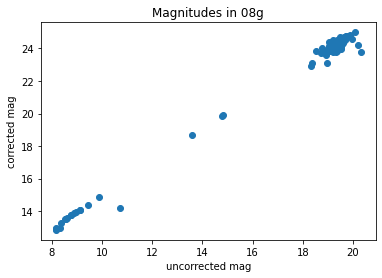

In [37]:
plt.title('Magnitudes in 08g')
plt.scatter(sub08g_uncorrected['MAG_AUTO'], sub08g_corrected['MAG_AUTO'])
plt.xlabel('uncorrected mag')
plt.ylabel('corrected mag')

Text(0, 0.5, 'corrected mag')

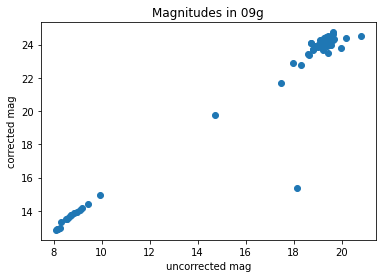

In [38]:
plt.title('Magnitudes in 09g')
plt.scatter(sub09g_uncorrected['MAG_AUTO'], sub09g_corrected['MAG_AUTO'])
plt.xlabel('uncorrected mag')
plt.ylabel('corrected mag')

Text(0, 0.5, 'corrected mag')

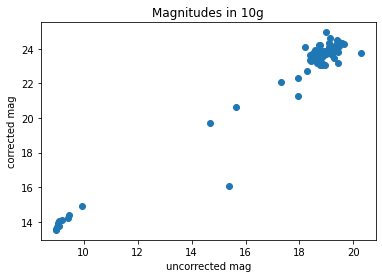

In [39]:
plt.title('Magnitudes in 10g')
plt.scatter(sub10g_uncorrected['MAG_AUTO'], sub10g_corrected['MAG_AUTO'])
plt.xlabel('uncorrected mag')
plt.ylabel('corrected mag')

Text(0, 0.5, 'corrected mag')

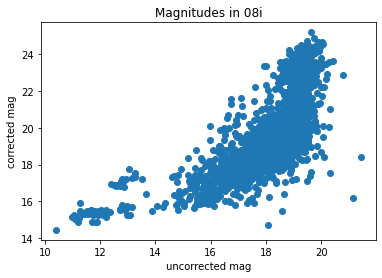

In [40]:
plt.title('Magnitudes in 08i')
plt.scatter(sub08i_uncorrected['MAG_AUTO'], sub08i_corrected['MAG_AUTO'])
plt.xlabel('uncorrected mag')
plt.ylabel('corrected mag')

Text(0, 0.5, 'corrected mag')

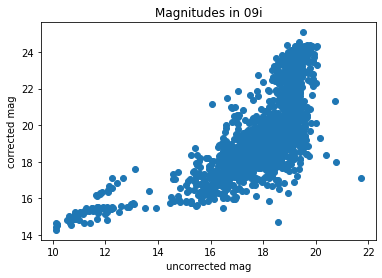

In [41]:
plt.title('Magnitudes in 09i')
plt.scatter(sub09i_uncorrected['MAG_AUTO'], sub09i_corrected['MAG_AUTO'])
plt.xlabel('uncorrected mag')
plt.ylabel('corrected mag')

Text(0, 0.5, 'corrected mag')

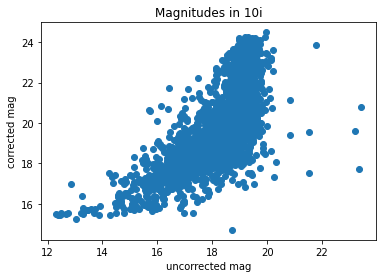

In [42]:
plt.title('Magnitudes in 10i')
plt.scatter(sub10i_uncorrected['MAG_AUTO'], sub10i_corrected['MAG_AUTO'])
plt.xlabel('uncorrected mag')
plt.ylabel('corrected mag')

In [43]:
#reseting index 
corrected_mag08g = sub08g_corrected['MAG_AUTO'].reset_index()
uncorrected_mag08g = sub08g_uncorrected['MAG_AUTO'].reset_index()

corrected_mag09g = sub09g_corrected['MAG_AUTO'].reset_index()
uncorrected_mag09g = sub09g_uncorrected['MAG_AUTO'].reset_index()

corrected_mag10g = sub10g_corrected['MAG_AUTO'].reset_index()
uncorrected_mag10g = sub10g_uncorrected['MAG_AUTO'].reset_index()

corrected_mag08i = sub08i_corrected['MAG_AUTO'].reset_index()
uncorrected_mag08i = sub08i_uncorrected['MAG_AUTO'].reset_index()

corrected_mag09i = sub09i_corrected['MAG_AUTO'].reset_index()
uncorrected_mag09i = sub09i_uncorrected['MAG_AUTO'].reset_index()

corrected_mag10i = sub10i_corrected['MAG_AUTO'].reset_index()
uncorrected_mag10i = sub10i_uncorrected['MAG_AUTO'].reset_index()

In [44]:
#finding the difference in magnitudes for the zero point
zero_pts08g = corrected_mag08g['MAG_AUTO'] - uncorrected_mag08g['MAG_AUTO']
zero_pt08g = np.nanmean(zero_pts08g)
zero_pt_err08g = np.nanstd(zero_pts08g)
print(zero_pt08g, zero_pt_err08g)

zero_pts09g = corrected_mag09g['MAG_AUTO'] - uncorrected_mag09g['MAG_AUTO']
zero_pt09g = np.nanmean(zero_pts09g)
zero_pt_err09g = np.nanstd(zero_pts09g)
print(zero_pt09g, zero_pt_err09g)

zero_pts10g = corrected_mag10g['MAG_AUTO'] - uncorrected_mag10g['MAG_AUTO']
zero_pt10g = np.nanmean(zero_pts10g)
zero_pt_err10g = np.nanstd(zero_pts10g)
print(zero_pt10g, zero_pt_err10g)

zero_pts08i = corrected_mag08i['MAG_AUTO'] - uncorrected_mag08i['MAG_AUTO']
zero_pt08i = np.nanmean(zero_pts08i)
zero_pt_err08i = np.nanstd(zero_pts08i)
print(zero_pt08i, zero_pt_err08i)

zero_pts09i = corrected_mag09i['MAG_AUTO'] - uncorrected_mag09i['MAG_AUTO']
zero_pt09i = np.nanmean(zero_pts09i)
zero_pt_err09i = np.nanstd(zero_pts09i)
print(zero_pt09i, zero_pt_err09i)

zero_pts10i = corrected_mag10i['MAG_AUTO'] - uncorrected_mag10i['MAG_AUTO']
zero_pt10i = np.nanmean(zero_pts10i)
zero_pt_err10i = np.nanstd(zero_pts10i)
print(zero_pt10i, zero_pt_err10i)

4.874043406593406 0.30336298274045626
4.72058656716418 0.9672614312515115
4.752352499999999 0.6133790296331871
1.6751390063944909 1.5393272391684103
1.6679273657289004 1.648311637107345
1.5664581678531286 1.3224754565885557


In [45]:
print(len(zero_pts08g))
print(len(zero_pts09g))
print(len(zero_pts10g))

print(len(zero_pts08i))
print(len(zero_pts09i))
print(len(zero_pts10i))

91
67
80
2033
1564
2669


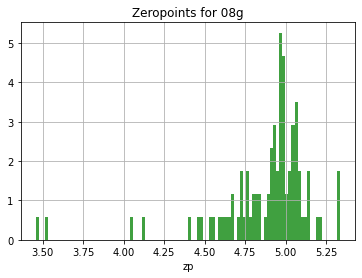

4.874043406593406 0.30336298274045626


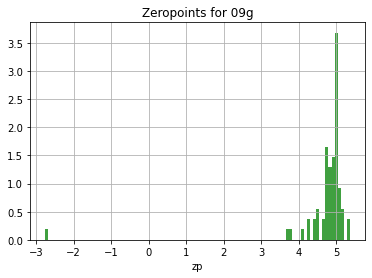

4.72058656716418 0.9672614312515115


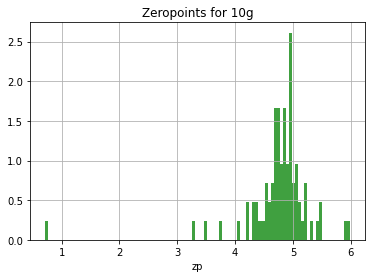

4.752352499999999 0.6133790296331871


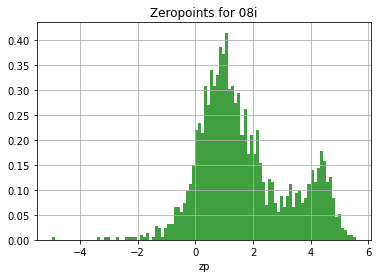

1.6751390063944909 1.5393272391684103


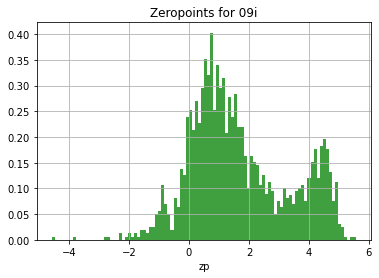

1.6679273657289004 1.648311637107345


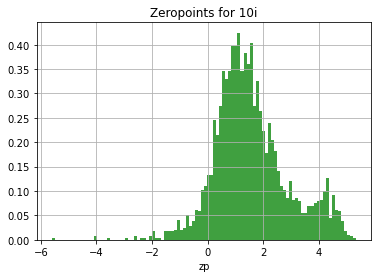

1.5664581678531286 1.3224754565885557


In [46]:
#plotting down the distribution of different zero points
plt.title('Zeropoints for 08g')
n, bins, patches = plt.hist(zero_pts08g, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()
print(zero_pt08g, zero_pt_err08g)

plt.title('Zeropoints for 09g')
n, bins, patches = plt.hist(zero_pts09g, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()
print(zero_pt09g, zero_pt_err09g)


plt.title('Zeropoints for 10g')
n, bins, patches = plt.hist(zero_pts10g, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()
print(zero_pt10g, zero_pt_err10g)


plt.title('Zeropoints for 08i')
n, bins, patches = plt.hist(zero_pts08i, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()
print(zero_pt08i, zero_pt_err08i)


plt.title('Zeropoints for 09i')
n, bins, patches = plt.hist(zero_pts09i, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()
print(zero_pt09i, zero_pt_err09i)


plt.title('Zeropoints for 10i')
n, bins, patches = plt.hist(zero_pts10i, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()
print(zero_pt10i, zero_pt_err10i)

In [47]:
#writing in the corrected csv file
sub08g['MAG_AUTO'] =  sub08g['MAG_AUTO'] + zero_pt08g
sub09g['MAG_AUTO'] =  sub09g['MAG_AUTO'] + zero_pt09g
sub10g['MAG_AUTO'] =  sub10g['MAG_AUTO'] + zero_pt10g

sub08i['MAG_AUTO'] =  sub08i['MAG_AUTO'] + zero_pt08i
sub09i['MAG_AUTO'] =  sub09i['MAG_AUTO'] + zero_pt09i
sub10i['MAG_AUTO'] =  sub10i['MAG_AUTO'] + zero_pt10i

In [48]:
sub08g.to_csv('GRB210605A5_20210608_g_stack_ext5.resamp_sub_withnans_SUB_CORRECTED.csv') #writing the corrected csv files
sub09g.to_csv('GRB210605A5_20210609_g_stack_ext5.resamp_sub_withnans_SUB_CORRECTED.csv')
sub10g.to_csv('GRB210605A5_20210610_g_stack_ext5.resamp_sub_withnans_SUB_CORRECTED.csv')

sub08i.to_csv('GRB210605A5_20210608_i_stack_ext5.resamp_sub_withnans_SUB_CORRECTED.csv')
sub09i.to_csv('GRB210605A5_20210609_i_stack_ext5.resamp_sub_withnans_SUB_CORRECTED.csv')
sub10i.to_csv('GRB210605A5_20210610_i_stack_ext5.resamp_sub_withnans_SUB_CORRECTED.csv')

In [49]:
sub08g = pd.read_csv('GRB210605A5_20210608_g_stack_ext5.resamp_sub_withnans_SUB_CORRECTED.csv')
sub08g.keys()

Index(['Unnamed: 0', 'NUMBER', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_RADIUS',
       'FLUX_APER', 'FLUXERR_APER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD',
       'FLAGS', 'CLASS_STAR', 'MAG_AUTO', 'MAGERR_AUTO', 'MAG_ISO',
       'MAGERR_ISO', 'BACKGROUND', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE',
       'THETA_SKY', 'ISOAREA_IMAGE', 'FWHM_IMAGE', 'FWHM_WORLD',
       'ISOAREAF_IMAGE', 'ELLIPTICITY'],
      dtype='object')

In [50]:
sub08g = sub08g.drop(columns = 'Unnamed: 0')
sub08g['MAG_AUTO']

0        22.713543
1        22.992743
2        23.775843
3        22.280843
4        23.039043
           ...    
12860    24.871643
12861    24.504343
12862    23.808343
12863    24.285243
12864    25.646243
Name: MAG_AUTO, Length: 12865, dtype: float64